## 🚀 Latar Belakang Proyek

Seiring dengan pesatnya perkembangan *Large Language Models* (LLM), analisis mengenai bagaimana model-model ini digunakan dan dipersepsikan oleh pengguna menjadi semakin penting.  
Proyek ini menganalisis data percakapan/komparasi antarmodel untuk:

- Memahami **tren popularitas** model,
- Mengidentifikasi **topik utama** (fitur n‑gram),
- Mengevaluasi **tingkat preferensi/kualitas** via **Win‑Rate** (+ Wilson 95% CI),
- Mengukur **efisiensi penyelesaian** via **Turns‑to‑Solve (TTS)**,
- Menilai **kecocokan model per kategori tugas** (*Fit‑for‑Purpose*: Coding, Penulisan, Analisis Data, Terjemahan).

Wawasan ini berguna untuk: **routing otomatis** model per topik, **bundling produk**, dan kebijakan **pricing/SLAs** yang lebih presisi.

## 🎯 Pertanyaan Bisnis

1. **Popularitas Model** — model mana yang paling sering digunakan?
2. **Topik Utama** — apa kata kunci/tema yang paling sering diminta pengguna?
3. **Win‑Rate** — model mana yang lebih disukai (beserta Wilson 95% CI)?
4. **Turns‑to‑Solve (TTS)** — berapa rata-rata giliran hingga “beres”? *(proxy “thanks/berhasil/works/dll”)*  
5. **Fit‑for‑Purpose** — model mana unggul per kategori tugas (Coding, Penulisan, Analisis Data, Terjemahan)?

In [37]:
# Imports & Setup
import os, re, warnings
from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

warnings.filterwarnings(
    "ignore",
    message="The default of observed=False is deprecated and will be changed to True in a future version of pandas",
    category=FutureWarning
)

sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (8, 4.8)

# Regex proxy 'beres'
OK_PAT = re.compile(
    r"(thanks|thank you|terima kasih|berhasil|works|solved|mantap|fixed?|oke+|ok|done|clear|yes|sip|resolved|great|perfect)",
    re.IGNORECASE,
)

# Aturan kategorisasi topik
TOPIC_RULES = {
    "Coding": re.compile(r"\b(code|coding|bug|function|class|method|api|regex|python|javascript|java|ts|typescript|cpp|golang|php|html|css|framework|compile|error)\b", re.I),
    "Analisis Data": re.compile(r"\b(data|dataset|pandas|numpy|stat(istik|s)?|regression|cluster|model(ing)?|visualisasi|plot|chart|csv|etl|eda)\b", re.I),
    "Terjemahan": re.compile(r"\b(translate|translat(e|ion)|terjemah|alih ?bahasa|english to indonesian|indonesian to english|b\.?inggris|b\.?indonesia)\b", re.I),
    "Penulisan": re.compile(r"\b(tulis|menulis|writing|essay|artikel|copy|caption|paragraf|ringkas|rangkuman|summary|email|surat|konten)\b", re.I),
}

# Stopwords ringan untuk n-gram
STOP = {
    "the","and","for","with","that","this","from","your","have","you","will","just","does","did","can","could",
    "would","there","here","into","them","then","than","what","when","where","which","some","about","like",
    "been","were","they","their","ours","ourselves",
    "kami","kita","kamu","anda","yang","dengan","untuk","atau","dari","pada","dalam","akan","saya","dia",
    "itu","ini","bisa","tidak","iya","dan","atau","jadi","agar","karena","kalau","sehingga"
}


In [38]:
def normalize_model_name(m: str) -> str:
    if m is None: return ""
    m = str(m).strip()
    m = m.replace(" - ", "-")
    m = re.sub(r"\s+", " ", m)
    return m

def _user_text_from_conv(conv):
    if not isinstance(conv, (list, tuple)): return ""
    parts = []
    for msg in conv:
        if isinstance(msg, dict) and msg.get("role") == "user":
            parts.append((msg.get("content") or "").strip())
    return " ".join(parts)

def is_solved_from_conv(conv) -> bool:
    if not isinstance(conv, (list, tuple)): return False
    for msg in reversed(conv):
        if isinstance(msg, dict) and msg.get("role") == "user":
            return bool(OK_PAT.search((msg.get("content") or "").lower()))
    return False

def topic_category_from_text(text: str) -> str:
    if not isinstance(text, str): return "Lainnya"
    for label in ["Coding", "Analisis Data", "Terjemahan", "Penulisan"]:
        if TOPIC_RULES[label].search(text):
            return label
    return "Lainnya"

def add_derived_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["model_norm"] = df["model"].apply(normalize_model_name)
    df["user_text"] = df["conversation"].apply(_user_text_from_conv)
    df["is_solved"] = df["conversation"].apply(is_solved_from_conv)
    df["topic_category"] = df["user_text"].apply(topic_category_from_text)
    df["turn"] = df["conversation"].apply(lambda conv: len(conv) if isinstance(conv, (list, tuple)) else np.nan)
    return df

def wilson_ci(k: float, n: float, z: float = 1.96):
    if n <= 0: return (0.0, 0.0)
    p = k / n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - adj)/denom
    hi = (centre + adj)/denom
    return lo, hi


In [39]:
# === Hugging Face Auth (Notebook) ===
import os, getpass
from huggingface_hub import login

HF_TOKEN = os.getenv("HF_TOKEN", "").strip()
if not HF_TOKEN:
    try:
        HF_TOKEN = getpass.getpass("Masukkan HF token (format: hf_xxx…): ").strip()
    except Exception as e:
        print("Tidak bisa membaca token via input:", e)
        HF_TOKEN = ""

if HF_TOKEN:
    try:
        login(token=HF_TOKEN, add_to_git_credential=False)
        print("✅ HF login sukses (session-only).")
    except Exception as e:
        print("⚠️ Gagal login HF:", e)
else:
    print("ℹ️ HF_TOKEN kosong. Jika dataset gated, pemuatan bisa gagal.")

✅ HF login sukses (session-only).


In [40]:
# Load Data (auto-detect skema + cache lokal)
SAMPLE_ROWS = 20000
LOCAL_CACHE = "data/arena55k_sample.parquet"
os.makedirs(os.path.dirname(LOCAL_CACHE), exist_ok=True)

# 1) Baca cache lokal jika ada
if os.path.exists(LOCAL_CACHE):
    try:
        df_raw = pd.read_parquet(LOCAL_CACHE)
        print(f"Menggunakan cache lokal: {LOCAL_CACHE} (rows={len(df_raw):,})")
    except Exception as e:
        print("Gagal baca cache lokal:", e)
        df_raw = None
else:
    df_raw = None

# 2) Unduh kalau belum ada
if df_raw is None:
    ds = load_dataset("lmsys/lmsys-arena-human-preference-55k", split="train")
    df_raw = pd.DataFrame(ds)
    df_save = df_raw.sample(SAMPLE_ROWS, random_state=42).reset_index(drop=True) if (SAMPLE_ROWS and SAMPLE_ROWS < len(df_raw)) else df_raw
    df_save.to_parquet(LOCAL_CACHE, index=False)
    print(f"Unduh & simpan cache ke {LOCAL_CACHE} (rows={len(df_save):,})")

# 3) Subsample untuk analisis notebook
if SAMPLE_ROWS and SAMPLE_ROWS < len(df_raw):
    df_raw = df_raw.sample(SAMPLE_ROWS, random_state=42).reset_index(drop=True)

# 4) Deteksi skema
has_conv = {"model_a","model_b","conversation_a","conversation_b"}.issubset(df_raw.columns)
has_pair = {"model_a","model_b","prompt","response_a","response_b","winner_model_a","winner_model_b","winner_tie"}.issubset(df_raw.columns)

if has_conv:
    SCHEMA = "conversation"
elif has_pair:
    SCHEMA = "pairwise"
else:
    raise ValueError(f"Skema dataset tidak dikenali. Kolom tersedia: {sorted(df_raw.columns.tolist())[:40]} ...")

print("Schema terdeteksi:", SCHEMA)


Menggunakan cache lokal: data/arena55k_sample.parquet (rows=20,000)
Schema terdeteksi: pairwise


In [41]:
# Normalisasi ke long format + win-rate (Wilson CI)
if SCHEMA == "conversation":
    df_a = df_raw[["model_a", "conversation_a"]].rename(columns={"model_a":"model","conversation_a":"conversation"})
    df_b = df_raw[["model_b", "conversation_b"]].rename(columns={"model_b":"model","conversation_b":"conversation"})
    df_long = pd.concat([df_a, df_b], ignore_index=True).dropna(subset=["model","conversation"])

    if "winner_model" in df_raw.columns:
        wins = df_raw["winner_model"].value_counts()
    elif "winner" in df_raw.columns:
        wins_a = df_raw.loc[df_raw["winner"]=="model_a","model_a"].value_counts()
        wins_b = df_raw.loc[df_raw["winner"]=="model_b","model_b"].value_counts()
        wins = wins_a.add(wins_b, fill_value=0)
    else:
        wins = pd.Series(dtype=float)
    apps = df_raw["model_a"].value_counts().add(df_raw["model_b"].value_counts(), fill_value=0)

elif SCHEMA == "pairwise":
    df_a = df_raw[["model_a","prompt","response_a","winner_model_a","winner_tie"]].copy()
    df_b = df_raw[["model_b","prompt","response_b","winner_model_b","winner_tie"]].copy()
    df_a.rename(columns={"model_a":"model","response_a":"response","winner_model_a":"won"}, inplace=True)
    df_b.rename(columns={"model_b":"model","response_b":"response","winner_model_b":"won"}, inplace=True)

    df_a["conversation"] = df_a.apply(lambda r: [{"role":"user","content":r["prompt"]},{"role":"assistant","content":r["response"]}], axis=1)
    df_b["conversation"] = df_b.apply(lambda r: [{"role":"user","content":r["prompt"]},{"role":"assistant","content":r["response"]}], axis=1)

    df_a.loc[df_a["winner_tie"]==1, "won"] = 0
    df_b.loc[df_b["winner_tie"]==1, "won"] = 0

    df_long = pd.concat([df_a[["model","conversation","won"]], df_b[["model","conversation","won"]]], ignore_index=True).dropna(subset=["model","conversation"])
    wins = df_long.groupby("model")["won"].sum(min_count=1)
    apps = df_long["model"].value_counts()

# Normalisasi index
wins.index = wins.index.astype(str).map(normalize_model_name)
apps.index = apps.index.astype(str).map(normalize_model_name)

# Derived kolom
df_long = add_derived_columns(df_long)

if SCHEMA == "pairwise":
    # Override is_solved berdasar 'won'; turn=2
    if "won" in df_long.columns:
        df_long["is_solved"] = df_long["won"].fillna(0).astype(int) == 1
    df_long["turn"] = 2

# Win-rate + Wilson CI
win_rate = (wins / apps).dropna().sort_values(ascending=False)
wr_df = pd.DataFrame({"wins": wins, "apps": apps}).fillna(0)
wr_df["win_rate"] = wr_df.apply(lambda r: (r["wins"]/r["apps"]) if r["apps"]>0 else np.nan, axis=1)
wr_df[["wr_lo","wr_hi"]] = wr_df.apply(lambda r: pd.Series(wilson_ci(r["wins"], r["apps"])), axis=1)
wr_df.index.name = "model_norm"

df_long.head()


,model,conversation,won,model_norm,user_text,is_solved,topic_category,turn
0,gpt-3.5-turbo-0613,"[{'role': 'user', 'content': '[""what does hell...",1,gpt-3.5-turbo-0613,"[""what does hello world mean""]",True,Lainnya,2
1,mistral-medium,"[{'role': 'user', 'content': '[""I ran a marath...",1,mistral-medium,"[""I ran a marathon in 3:12:00 weighting 84kg. ...",True,Lainnya,2
2,gpt-4-0314,"[{'role': 'user', 'content': '[""Below is an in...",0,gpt-4-0314,"[""Below is an instruction that describes a tas...",False,Lainnya,2
3,openchat-3.5,"[{'role': 'user', 'content': '[""How do I run s...",1,openchat-3.5,"[""How do I run static analysis with gcc in QT ...",True,Lainnya,2
4,codellama-34b-instruct,"[{'role': 'user', 'content': '[""What did the m...",1,codellama-34b-instruct,"[""What did the music producer \u00d8fdream die...",True,Lainnya,2


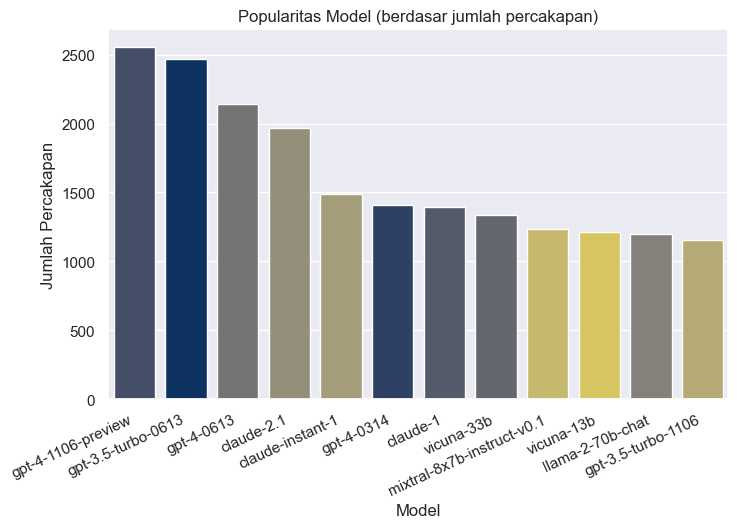

N efektif: 19,574 percakapan | Model unik: 12


In [42]:
# === No. 1: Popularitas Model ===
top_n_pop = 12
order = df_long["model_norm"].value_counts().head(top_n_pop).index
df_pop = df_long[df_long["model_norm"].isin(order)]

ax = sns.countplot(
    data=df_pop, x="model_norm", order=order,
    hue="model_norm", legend=False, dodge=False, palette="cividis"
)
ax.set_title("Popularitas Model (berdasar jumlah percakapan)")
ax.set_xlabel("Model"); ax.set_ylabel("Jumlah Percakapan")
plt.xticks(rotation=25, ha="right")
plt.show()

print(f"N efektif: {len(df_pop):,} percakapan | Model unik: {len(order)}")


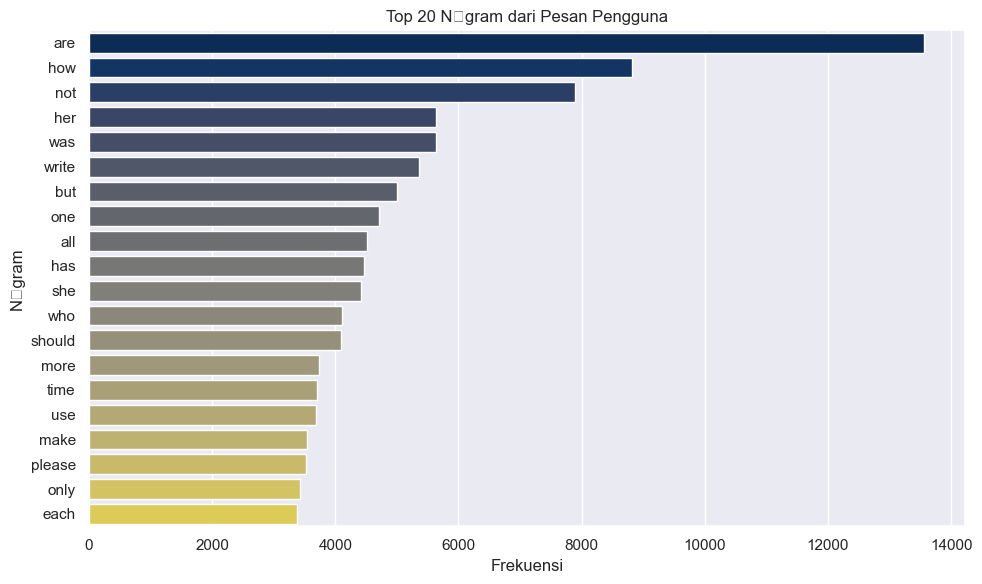

N efektif: 40,000 percakapan | Token unik terpilih: 20


In [43]:
# === No. 2: Topik Utama (n-gram) ===
import re, io, warnings, contextlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsi: df_long & STOP sudah tersedia dari sel sebelumnya

# Hitung n-gram
texts = df_long["user_text"].astype(str).str.lower().tolist()
all_text = " ".join(texts)
tokens = re.findall(r"[a-zA-Z]{3,}", all_text)
tokens = [w for w in tokens if w not in STOP]
bigrams = [" ".join(tokens[i:i+2]) for i in range(len(tokens)-1)]
merged = tokens + bigrams
freq = pd.Series(merged).value_counts().head(20)

# Siapkan DF untuk plot
df_topics = pd.DataFrame({"Kata Kunci": freq.index, "Frekuensi": freq.values})

# Plot (diamkan semua warning & output)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    buf_out, buf_err = io.StringIO(), io.StringIO()
    with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.barplot(
            data=df_topics, x="Frekuensi", y="Kata Kunci",
            hue="Kata Kunci", legend=False, dodge=False, palette="cividis", ax=ax
        )
        ax.set_title("Top 20 N‑gram dari Pesan Pengguna")
        ax.set_xlabel("Frekuensi"); ax.set_ylabel("N‑gram")
        plt.tight_layout()
        plt.show()
        plt.close(fig)

# (Opsional) Tampilkan ringkas info (tanpa warning)
print(f"N efektif: {len(df_long):,} percakapan | Token unik terpilih: {len(df_topics)}")


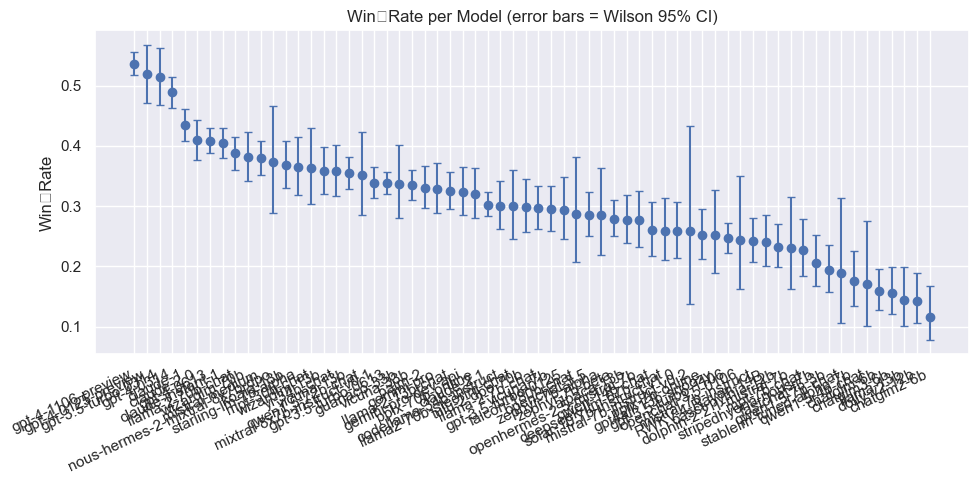

Total Apps (pasangan kompetisi): 40,000


In [44]:
# === No. 3: Win‑Rate (Wilson 95% CI) ===
import io, warnings, contextlib
import numpy as np
import matplotlib.pyplot as plt

# Asumsi: wr_df sudah tersedia dari sel sebelumnya

wr_view = wr_df.sort_values("win_rate", ascending=False).copy()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    buf_out, buf_err = io.StringIO(), io.StringIO()
    with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(wr_view))
        ax.errorbar(
            x, wr_view["win_rate"].values,
            yerr=[wr_view["win_rate"].values - wr_view["wr_lo"].values,
                  wr_view["wr_hi"].values - wr_view["win_rate"].values],
            fmt="o", capsize=3
        )
        ax.set_xticks(x)
        ax.set_xticklabels(wr_view.index, rotation=25, ha="right")
        ax.set_ylabel("Win‑Rate")
        ax.set_title("Win‑Rate per Model (error bars = Wilson 95% CI)")
        plt.tight_layout()
        plt.show()
        plt.close(fig)

print(f"Total Apps (pasangan kompetisi): {int(wr_view['apps'].sum()):,}")


,n_solved,mean,median,p75
model_norm,,,,
RWKV-4-Raven-14B,93,2.0,2.0,2.0
alpaca-13b,131,2.0,2.0,2.0
chatglm-6b,71,2.0,2.0,2.0
chatglm2-6b,23,2.0,2.0,2.0
chatglm3-6b,52,2.0,2.0,2.0
...,...,...,...,...
wizardlm-13b,203,2.0,2.0,2.0
wizardlm-70b,216,2.0,2.0,2.0
yi-34b-chat,175,2.0,2.0,2.0


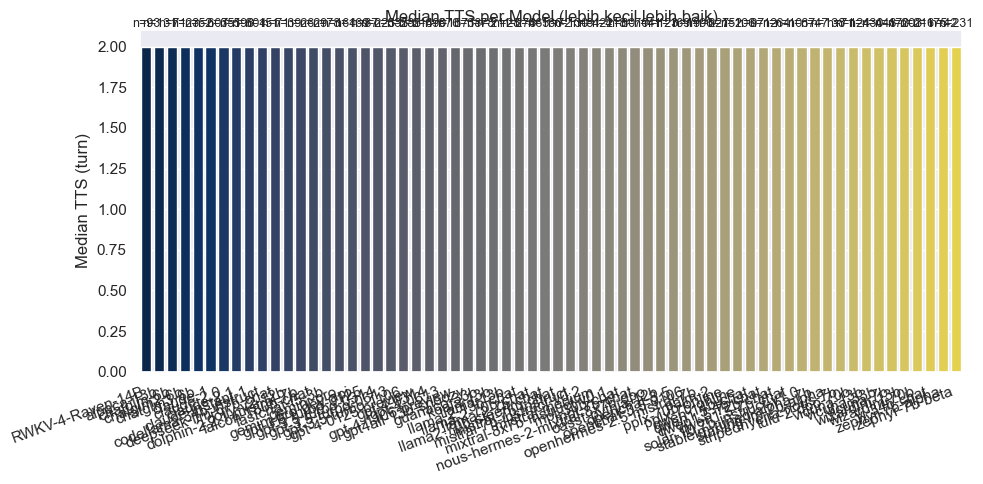

N efektif (percakapan 'beres' & turn ≥ 2): 13,818


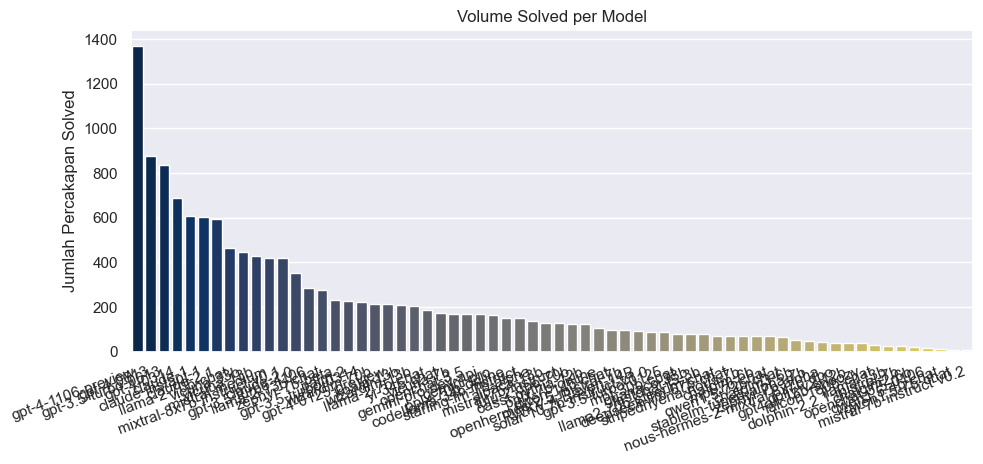

In [45]:
# === No. 4: TTS (Turns‑to‑Solve) ===
import io, warnings, contextlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsi:
# - df_long tersedia
# - SCHEMA berisi "conversation" atau "pairwise"
# - compute_tts(df_in, min_turn, schema) & get_tts_samples(df_in, min_turn, schema) sudah didefinisikan

MIN_TURN = 3
eff_min = 2 if SCHEMA == "pairwise" else MIN_TURN

# Hitung ringkasan TTS
tts_stats = compute_tts(df_long, min_turn=MIN_TURN, schema=SCHEMA)

# Tampilkan tabel (tanpa warning)
display(tts_stats.round(2))

# ---- Bar chart median TTS per model (dengan hue agar bebas FutureWarning) ----
if not tts_stats.empty:
    # siapkan DF untuk plot bar
    tts_plot = tts_stats.reset_index().rename(columns={"index":"model_norm"}) if "index" in tts_stats.reset_index().columns else tts_stats.reset_index()
    order = tts_stats.index.tolist()

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        buf_out, buf_err = io.StringIO(), io.StringIO()
        with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
            fig, ax = plt.subplots(figsize=(10, 5))
            sns.barplot(
                data=tts_plot, x="model_norm", y="median",
                order=order, hue="model_norm", legend=False, dodge=False, palette="cividis", ax=ax
            )
            ax.set_xlabel(""); ax.set_ylabel("Median TTS (turn)")
            ax.set_title("Median TTS per Model (lebih kecil lebih baik)")
            plt.xticks(rotation=20, ha="right")
            for i, model_name in enumerate(order):
                n = int(tts_stats.loc[model_name, "n_solved"])
                ax.text(i, float(tts_stats.loc[model_name, "median"]) + 0.1, f"n={n}",
                        ha="center", va="bottom", fontsize=9)
            plt.tight_layout()
            plt.show()
            plt.close(fig)

print(f"N efektif (percakapan 'beres' & turn ≥ {eff_min}): {int(tts_stats['n_solved'].sum()) if not tts_stats.empty else 0:,}")

# ---- Grafik tambahan: distribusi/boxplot atau volume solved, sesuai schema ----
tts_samples = get_tts_samples(df_long, min_turn=MIN_TURN, schema=SCHEMA)

if SCHEMA == "pairwise":
    # TTS ~ 2 → tampilkan volume solved per model
    if not tts_stats.empty:
        solved_counts = tts_stats["n_solved"].sort_values(ascending=False)
        df_sc = solved_counts.reset_index()
        df_sc.columns = ["model_norm", "n_solved"]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            buf_out, buf_err = io.StringIO(), io.StringIO()
            with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
                fig_c, ax_c = plt.subplots(figsize=(10, 4.8))
                sns.barplot(
                    data=df_sc, x="model_norm", y="n_solved",
                    hue="model_norm", legend=False, dodge=False, palette="cividis", ax=ax_c
                )
                ax_c.set_xlabel(""); ax_c.set_ylabel("Jumlah Percakapan Solved")
                ax_c.set_title("Volume Solved per Model")
                plt.xticks(rotation=20, ha="right")
                plt.tight_layout()
                plt.show()
                plt.close(fig_c)
else:
    # Conversation mode → histogram & boxplot
    if not tts_samples.empty:
        # Histogram (Matplotlib - aman, tapi tetap kita bungkam warning/output)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            buf_out, buf_err = io.StringIO(), io.StringIO()
            with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
                max_turns = int(np.nanmax(tts_samples["turn"])) if not tts_samples["turn"].isna().all() else eff_min
                bins = range(1, max(5, max_turns) + 2)
                fig_h, ax_h = plt.subplots(figsize=(9, 4.8))
                ax_h.hist(tts_samples["turn"].dropna(), bins=bins)
                ax_h.set_xlabel("Jumlah Turn"); ax_h.set_ylabel("Frekuensi")
                ax_h.set_title("Histogram TTS (Percakapan Solved)")
                plt.tight_layout()
                plt.show()
                plt.close(fig_h)

        # Boxplot Top‑K by n_solved
        TOPK = 10
        top_models_tts = tts_samples["model_norm"].value_counts().head(TOPK).index
        df_box = tts_samples[tts_samples["model_norm"].isin(top_models_tts)]

        if not df_box.empty:
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                buf_out, buf_err = io.StringIO(), io.StringIO()
                with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
                    fig_b, ax_b = plt.subplots(figsize=(10, 5))
                    sns.boxplot(
                        data=df_box, x="model_norm", y="turn",
                        order=top_models_tts, hue="model_norm", legend=False, dodge=False, palette="cividis", ax=ax_b
                    )
                    ax_b.set_xlabel(""); ax_b.set_ylabel("TTS (turn)")
                    ax_b.set_title("Sebaran TTS per Model (Top‑K by n_solved)")
                    plt.xticks(rotation=20, ha="right")
                    plt.tight_layout()
                    plt.show()
                    plt.close(fig_b)


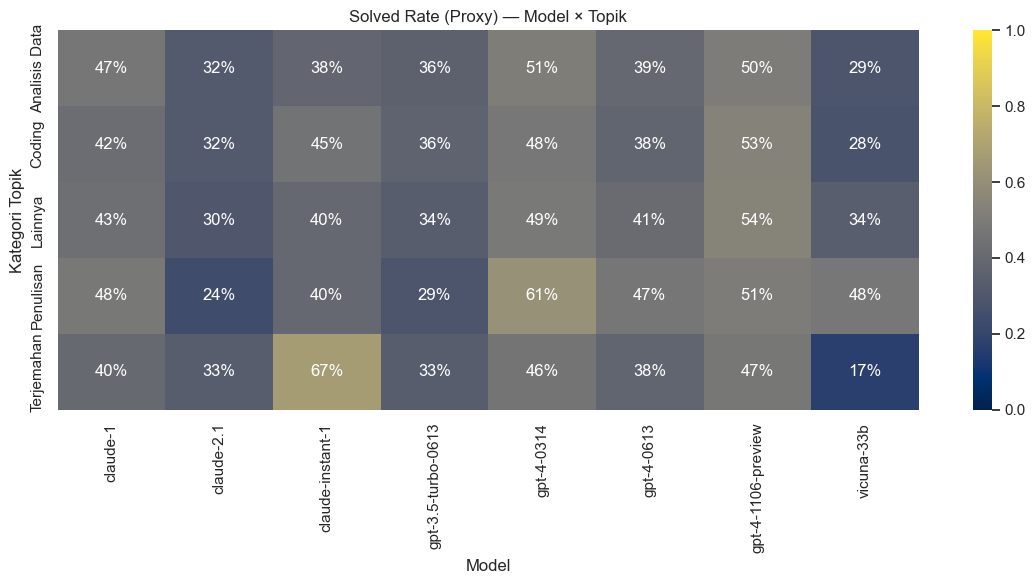

,Topik,Model,N,Solved Rate (%)
0,Analisis Data,gpt-4-0314,49,51.0
1,Coding,gpt-4-1106-preview,272,53.3
2,Lainnya,gpt-4-1106-preview,2089,54.0
3,Penulisan,gpt-4-0314,31,61.3


In [46]:
# === No. 5: Fit‑for‑Purpose (Heatmap Model × Topik + Leaders) ===
import io, warnings, contextlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asumsi: df_long sudah tersedia dari sel sebelumnya (punya kolom: model_norm, topic_category, is_solved)

TOP_N_HEAT = 8       # banyak model terpopuler yg ditampilkan di heatmap
MIN_N_LEADER = 30    # ambang N untuk "juara per topik"

# Hitung perf (N & solved_rate) untuk kombinasi topik × model
top_models = df_long["model_norm"].value_counts().head(TOP_N_HEAT).index
perf = (
    df_long[df_long["model_norm"].isin(top_models)]
    .groupby(["topic_category", "model_norm"], observed=True)
    .agg(n=("model_norm", "size"), solved_rate=("is_solved", "mean"))
    .reset_index()
)

# Pivot ke heatmap (isi 0 untuk NaN agar konsisten skala)
heat = perf.pivot(index="topic_category", columns="model_norm", values="solved_rate").fillna(0)

# Plot heatmap (tanpa warning & tanpa pesan stdout/stderr)
if not heat.empty:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        buf_out, buf_err = io.StringIO(), io.StringIO()
        with contextlib.redirect_stdout(buf_out), contextlib.redirect_stderr(buf_err):
            fig, ax = plt.subplots(figsize=(min(12, 2 + 1.2 * len(heat.columns)), 6))
            sns.heatmap(heat, cmap="cividis", vmin=0, vmax=1, annot=True, fmt=".0%")
            ax.set_xlabel("Model"); ax.set_ylabel("Kategori Topik")
            ax.set_title("Solved Rate (Proxy) — Model × Topik")
            plt.tight_layout()
            plt.show()
            plt.close(fig)

# Juara per topik (leaders) dengan ambang N — ditampilkan sebagai tabel
leaders = (
    perf[perf["n"] >= MIN_N_LEADER]
    .sort_values(["topic_category", "solved_rate"], ascending=[True, False])
    .groupby("topic_category", observed=True)
    .head(1)
    .reset_index(drop=True)
)

# Siapkan tabel leaders_show untuk ditampilkan & reuse (mis. artifacts)
leaders_show = (
    leaders.assign(**{"Solved Rate (%)": (leaders["solved_rate"] * 100).round(1)})
           .rename(columns={"topic_category": "Topik", "model_norm": "Model", "n": "N"})
           [["Topik", "Model", "N", "Solved Rate (%)"]]
)

# Tampilkan tabel (tanpa print tambahan)
display(leaders_show)


## ✅ Kesimpulan

1. **Popularitas Model** – Beberapa model mendominasi jumlah percakapan; ini mengindikasikan preferensi awal/brand awareness yang kuat.  
2. **Topik Utama** – Kata kunci n‑gram menegaskan fokus pada *Coding*, *Penulisan*, dan *Analisis Data* sebagai use‑case utama.  
3. **Win‑Rate** – Perbedaan win‑rate antar model terlihat jelas; bandingkan dengan **Wilson 95% CI** untuk menghindari bias sampel kecil.  
4. **TTS (Efisiensi)** – Model tertentu mampu menyelesaikan percakapan ‘beres’ dengan lebih sedikit giliran; gunakan **median TTS** untuk membandingkan efisiensi.  
5. **Fit‑for‑Purpose** – “Juara per topik” berbeda-beda; ini mendukung strategi **routing otomatis** dan **bundling produk** (mis. coding vs penulisan).

### Ringkasan Naratif
Secara keseluruhan, analisis menunjukkan fokus penggunaan LLM pada tiga klaster utama (coding, penulisan, analisis data), dengan dominasi sejumlah model populer. Win‑Rate memetakan preferensi pengguna namun perlu dibaca bersama rentang kepercayaannya. TTS mengungkap efisiensi relatif; beberapa model menyelesaikan tugas dengan lebih sedikit giliran. Heatmap Fit‑for‑Purpose menegaskan bahwa keunggulan setiap model bersifat kontekstual per topik—ini membuka peluang routing otomatis, bundling produk, dan pengelolaan biaya/SLAs yang lebih presisi.

In [48]:
# (Opsional) Simpan artifacts ringkasan
os.makedirs("artifacts", exist_ok=True)
df_long.to_parquet("artifacts/df_long.parquet", index=False)
wr_df.to_csv("artifacts/win_rate_wilson.csv")
try:
    tts_stats.to_csv("artifacts/tts_stats.csv")
except NameError:
    pass
try:
    perf.to_csv("artifacts/fit_for_purpose_perf.csv", index=False)
    leaders_show.to_csv("artifacts/fit_for_purpose_leaders.csv", index=False)
except NameError:
    pass
print("Artifacts saved to /artifacts")


Artifacts saved to /artifacts


In [2]:
# export_usage_csv.py
import os, re, random
from math import sqrt
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

try:
    from datasets import load_dataset  # pip install datasets
    HAS_HF = True
except Exception:
    HAS_HF = False

# ---------- Konfigurasi ----------
OUTPUT_DIR = "data"
PARQUET_CACHE = os.path.join(OUTPUT_DIR, "arena55k_sample.parquet")
CSV_USAGE = os.path.join(OUTPUT_DIR, "usage.csv")
CSV_WINRT = os.path.join(OUTPUT_DIR, "winrate.csv")
CSV_NGRAM = os.path.join(OUTPUT_DIR, "ngrams.csv")

SAMPLE_ROWS = 20000
SYNTHETIC_DAYS = 90
RANDOM_SEED = 42

OK_PAT = re.compile(
    r"(thanks|thank you|terima kasih|berhasil|works|solved|mantap|fixed?|oke+|ok|done|clear|yes|sip|resolved|great|perfect)",
    re.IGNORECASE,
)

TOPIC_RULES = {
    "Coding": re.compile(r"\b(code|coding|bug|function|class|method|api|regex|python|javascript|java|ts|typescript|cpp|golang|php|html|css|framework|compile|error)\b", re.I),
    "Analisis Data": re.compile(r"\b(data|dataset|pandas|numpy|stat(istik|s)?|regression|cluster|model(ing)?|visualisasi|plot|chart|csv|etl|eda)\b", re.I),
    "Terjemahan": re.compile(r"\b(translate|translat(e|ion)|terjemah|alih ?bahasa|english to indonesian|indonesian to english|b\.?inggris|b\.?indonesia)\b", re.I),
    "Penulisan": re.compile(r"\b(tulis|menulis|writing|essay|artikel|copy|caption|paragraf|ringkas|rangkuman|summary|email|surat|konten)\b", re.I),
}

STOP = set("""
the and for with that this from your have you will just does did can could would there here into them then than
what when where which some about like been were they their ours ourselves
kami kita kamu anda yang dengan untuk atau dari pada dalam akan saya dia itu ini bisa tidak iya dan atau jadi agar karena kalau sehingga
""".split())

# ---------- Helpers ----------
def normalize_model_name(m: str) -> str:
    if m is None: return ""
    m = str(m).strip()
    m = m.replace(" - ", "-")
    m = re.sub(r"\s+", " ", m)
    return m

def _user_text_from_conv(conv):
    if not isinstance(conv, (list, tuple)): return ""
    parts = []
    for msg in conv:
        if isinstance(msg, dict) and msg.get("role") == "user":
            parts.append((msg.get("content") or "").strip())
    return " ".join(parts)

def is_solved_from_conv(conv) -> bool:
    if not isinstance(conv, (list, tuple)): return False
    for msg in reversed(conv):
        if isinstance(msg, dict) and msg.get("role") == "user":
            return bool(OK_PAT.search((msg.get("content") or "").lower()))
    return False

def topic_category_from_text(text: str) -> str:
    if not isinstance(text, str) or not text: return "Lainnya"
    for label, pat in TOPIC_RULES.items():
        if pat.search(text): return label
    return "Lainnya"

def synth_date_series(n: int, days: int = SYNTHETIC_DAYS, seed: int = RANDOM_SEED):
    rng = random.Random(seed)
    today = datetime.today().date()
    return [today - timedelta(days=rng.randint(0, max(0, days))) for _ in range(n)]

def load_source(sample_rows=SAMPLE_ROWS):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    if os.path.exists(PARQUET_CACHE):
        df_raw = pd.read_parquet(PARQUET_CACHE)
        if sample_rows and sample_rows < len(df_raw):
            df_raw = df_raw.sample(sample_rows, random_state=RANDOM_SEED).reset_index(drop=True)
        return df_raw, "cache"
    if not HAS_HF:
        raise RuntimeError(
            "Cache parquet tidak ditemukan dan paket `datasets` tidak tersedia. "
            "Instal `datasets` atau sediakan cache di 'data/arena55k_sample.parquet'."
        )
    ds = load_dataset("lmsys/lmsys-arena-human-preference-55k", split="train")
    df_raw = pd.DataFrame(ds)
    df_save = df_raw.sample(sample_rows, random_state=RANDOM_SEED).reset_index(drop=True) if sample_rows < len(df_raw) else df_raw
    df_save.to_parquet(PARQUET_CACHE, index=False)
    return df_save, "huggingface"

def to_long_schema(df_raw: pd.DataFrame) -> pd.DataFrame:
    has_conv = {"model_a","model_b","conversation_a","conversation_b"}.issubset(df_raw.columns)
    has_pair = {"model_a","model_b","prompt","response_a","response_b","winner_model_a","winner_model_b","winner_tie"}.issubset(df_raw.columns)

    if has_conv:
        df_a = df_raw[["model_a", "conversation_a"]].rename(columns={"model_a":"model","conversation_a":"conversation"})
        df_b = df_raw[["model_b", "conversation_b"]].rename(columns={"model_b":"model","conversation_b":"conversation"})
        df_long = pd.concat([df_a, df_b], ignore_index=True).dropna(subset=["model","conversation"])
        df_long["model_norm"]     = df_long["model"].apply(normalize_model_name)
        df_long["user_text"]      = df_long["conversation"].apply(_user_text_from_conv)
        df_long["is_solved"]      = df_long["conversation"].apply(is_solved_from_conv)
        df_long["topic_category"] = df_long["user_text"].apply(topic_category_from_text)
        df_long["turn"]           = df_long["conversation"].apply(lambda conv: len(conv) if isinstance(conv,(list,tuple)) else np.nan)
        df_long["schema"]         = "conversation"
        return df_long

    if has_pair:
        a = df_raw[["model_a","prompt","response_a","winner_model_a","winner_tie"]].copy()
        b = df_raw[["model_b","prompt","response_b","winner_model_b","winner_tie"]].copy()
        a.rename(columns={"model_a":"model","response_a":"response","winner_model_a":"won"}, inplace=True)
        b.rename(columns={"model_b":"model","response_b":"response","winner_model_b":"won"}, inplace=True)
        a.loc[a["winner_tie"]==1, "won"] = 0
        b.loc[b["winner_tie"]==1, "won"] = 0
        a["conversation"] = a.apply(lambda r: [{"role":"user","content":r["prompt"]},{"role":"assistant","content":r["response"]}], axis=1)
        b["conversation"] = b.apply(lambda r: [{"role":"user","content":r["prompt"]},{"role":"assistant","content":r["response"]}], axis=1)

        df_long = pd.concat([a[["model","conversation","won","prompt"]], b[["model","conversation","won","prompt"]]], ignore_index=True)
        df_long.dropna(subset=["model","conversation"], inplace=True)
        df_long["model_norm"]     = df_long["model"].apply(normalize_model_name)
        df_long["user_text"]      = df_long["prompt"].astype(str)
        df_long["is_solved"]      = df_long["won"].fillna(0).astype(int) == 1  # proxy
        df_long["topic_category"] = df_long["user_text"].apply(topic_category_from_text)
        df_long["turn"]           = 2
        df_long["schema"]         = "pairwise"
        return df_long

    raise ValueError("Skema dataset tidak dikenali: kolom kunci tidak lengkap.")

def build_usage(df_long: pd.DataFrame) -> pd.DataFrame:
    if df_long.empty:
        return pd.DataFrame(columns=["date","model","user_text","topic","tts","is_solved","fit_score"])
    n = len(df_long)
    dates = synth_date_series(n, days=SYNTHETIC_DAYS, seed=RANDOM_SEED)
    out = pd.DataFrame({
        "date": pd.to_datetime(dates).date,
        "model": df_long["model_norm"].astype(str),
        "user_text": df_long["user_text"].astype(str),
        "topic": df_long["topic_category"].astype(str),
        "tts":   pd.to_numeric(df_long["turn"], errors="coerce"),
        "is_solved": df_long["is_solved"].astype(int)
    })
    out["tts"] = out["tts"].fillna(2).clip(lower=1)
    out["fit_score"] = (out["is_solved"] * 100).astype(float)
    return out

def wilson_ci(k, n, z=1.96):
    if n <= 0: return (0.0, 0.0)
    p = k / n
    denom = 1 + z*z/n
    centre = p + z*z/(2*n)
    adj = z * sqrt((p*(1-p) + z*z/(4*n))/n)
    lo = (centre - adj)/denom
    hi = (centre + adj)/denom
    return lo, hi

def build_winrate(usage: pd.DataFrame) -> pd.DataFrame:
    grp = usage.groupby("model", as_index=True)
    wr = grp.agg(wins=("is_solved","sum"), apps=("model","size")).astype({"wins":"int","apps":"int"})
    wr["win_rate"] = wr["wins"] / wr["apps"]
    wr[["wr_lo","wr_hi"]] = wr.apply(lambda r: pd.Series(wilson_ci(r["wins"], r["apps"])), axis=1)
    return wr.reset_index()

def top_ngrams(texts: pd.Series, top_k: int = 20) -> pd.DataFrame:
    all_text = " ".join(map(str, texts)).lower()
    tokens = re.findall(r"[a-zA-Z]{3,}", all_text)
    tokens = [w for w in tokens if w not in STOP]
    bigrams = [" ".join(tokens[i:i+2]) for i in range(len(tokens)-1)]
    merged = tokens + bigrams
    vc = pd.Series(merged).value_counts().head(top_k)
    return pd.DataFrame({"term": vc.index, "freq": vc.values})

def main():
    print("→ Memuat sumber data …")
    df_raw, source = load_source(sample_rows=SAMPLE_ROWS)
    print(f"   sumber: {source}, baris: {len(df_raw):,}")

    print("→ Menyelaraskan skema …")
    df_long = to_long_schema(df_raw)
    print(f"   long rows: {len(df_long):,}")

    print("→ Menurunkan usage.csv …")
    usage = build_usage(df_long)
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    usage.to_csv(CSV_USAGE, index=False)
    print(f"   ✓ {CSV_USAGE} (rows={len(usage):,})")

    print("→ Menurunkan winrate.csv …")
    wr = build_winrate(usage)
    wr.to_csv(CSV_WINRT, index=False)
    print(f"   ✓ {CSV_WINRT} (models={len(wr):,})")

    print("→ Menurunkan ngrams.csv …")
    ngr = top_ngrams(usage["user_text"].astype(str), top_k=20)
    ngr.to_csv(CSV_NGRAM, index=False)
    print(f"   ✓ {CSV_NGRAM} (terms={len(ngr):,})")

    print("Selesai.")
    print("Kolom usage.csv:", list(usage.columns))

if __name__ == "__main__":
    main()


→ Memuat sumber data …
   sumber: cache, baris: 20,000
→ Menyelaraskan skema …
   long rows: 40,000
→ Menurunkan usage.csv …
   ✓ data\usage.csv (rows=40,000)
→ Menurunkan winrate.csv …
   ✓ data\winrate.csv (models=64)
→ Menurunkan ngrams.csv …
   ✓ data\ngrams.csv (terms=20)
Selesai.
Kolom usage.csv: ['date', 'model', 'user_text', 'topic', 'tts', 'is_solved', 'fit_score']
